   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
--- Logistic Regression ---
Accuracy: 0.6041666666666666
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00        16
           2       0.66      0.75      0.70       204
     

C:\Users\Priya\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- XGBoost ---
Accuracy: 0.6520833333333333
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.17      0.06      0.09        16
           2       0.71      0.76      0.74       204
           3       0.62      0.69      0.65       192
           4       0.62      0.38      0.47        60
           5       0.33      0.20      0.25         5

    accuracy                           0.65       480
   macro avg       0.57      0.35      0.37       480
weighted avg       0.64      0.65      0.64       480

Confusion Matrix:
[[  0   1   2   0   0   0]
 [  0   1  11   4   0   0]
 [  0   2 156  45   1   0]
 [  0   2  47 132  11   0]
 [  0   0   4  31  23   2]
 [  0   0   0   2   2   1]]



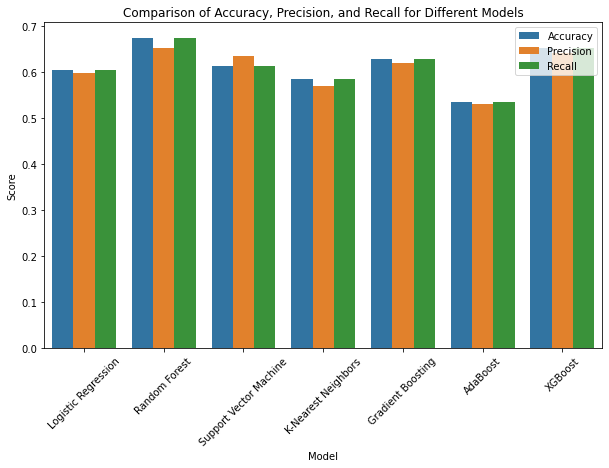

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}


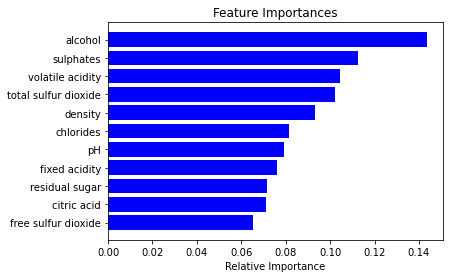

Provide the following features to predict the wine quality:
Enter value for fixed acidity (recommended range: 4.0 to 16.0): 5
Enter value for volatile acidity (recommended range: 0.1 to 1.58): 0.9
Enter value for citric acid (recommended range: 0.0 to 1.66): 0.99
Enter value for residual sugar (recommended range: 0.9 to 15.5): 10
Enter value for chlorides (recommended range: 0.012 to 0.611): 0.4
Enter value for free sulfur dioxide (recommended range: 1.0 to 72.0): 2.0
Enter value for total sulfur dioxide (recommended range: 6.0 to 289.0): 10
Enter value for density (recommended range: 0.99 to 1.0036): 1.0
Enter value for pH (recommended range: 2.74 to 4.01): 3.0
Enter value for sulphates (recommended range: 0.33 to 2.0): 0.4
Enter value for alcohol (recommended range: 8.4 to 14.9): 10
The predicted wine quality based on the provided features is: 5 (Good quality)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
print(data.head(3))

# Separate features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

# Transform the target variable y to zero-indexed labels
y_transformed = y - 3  # Subtracting 3 will map the labels from 3-8 to 0-5

# Split the data into training and testing sets using the transformed labels
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.3, random_state=42, stratify=y_transformed)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": []
}

# Train and Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(report['weighted avg']['precision'])
    results["Recall"].append(report['weighted avg']['recall'])
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=1)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    
results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('Comparison of Accuracy, Precision, and Recall for Different Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Feature importance from Random Forest
importances = best_model.feature_importances_
indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(6,4))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importances[indices], color='b', align='center')
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Provide the following features to predict the wine quality:
print("Provide the following features to predict the wine quality:")

input_data = {}
feature_ranges = {
    'fixed acidity': (4.0, 16.0),
    'volatile acidity': (0.10, 1.58),
    'citric acid': (0.00, 1.66),
    'residual sugar': (0.9, 15.5),
    'chlorides': (0.012, 0.611),
    'free sulfur dioxide': (1.0, 72.0),
    'total sulfur dioxide': (6.0, 289.0),
    'density': (0.9900, 1.0036),
    'pH': (2.74, 4.01),
    'sulphates': (0.33, 2.00),
    'alcohol': (8.4, 14.9)
}

for feature, (min_val, max_val) in feature_ranges.items():
    value = float(input(f"Enter value for {feature} (recommended range: {min_val} to {max_val}): "))
    input_data[feature] = value

# Convert the input_data to a DataFrame for prediction
input_df = pd.DataFrame([input_data])

# Scale the input features
input_scaled = scaler.transform(input_df)

# Predict the quality using the best model
predicted_quality = best_model.predict(input_scaled) + 3  # Reverting to original labels

# Define quality ratings
quality_ratings = {
    3: "Poor quality",
    4: "Fair quality",
    5: "Good quality",
    6: "Very good quality",
    7: "Excellent quality",
    8: "Superior quality",
    9: "Outstanding quality"
}

# Print the predicted quality
quality_score = predicted_quality[0]
print(f"The predicted wine quality based on the provided features is: {quality_score} ({quality_ratings.get(quality_score, 'Unknown quality')})")
